In [63]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 01:  Data Import
 * Import data
 * Filter targets/ nontargets
 * One hot encoding and other pre-processing
 * Split

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, including:
* https://www.kaggle.com/code/mariiagusarova/feature-selection-techniques
* https://www.kaggle.com/datasets/wordsforthewise/lending-club/
* https://www.kaggle.com/code/wordsforthewise/eda-with-python/notebook

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split

In [4]:
setup.plot_defaults()

## Import Data and Filter

In [5]:
loans_init = pd.read_csv(setup.input_path,  dtype=setup.input_dtypes,
                        parse_dates = setup.input_dates)

##### Filter to include only paid or unpaid loans

In [6]:
loans_init = loans_init[loans_init['loan_status'].isin(['Fully Paid',  'Charged Off'])]

In [7]:
loans_init.shape

(1345310, 151)

##### Create the target feature (0/1) that indicates a default

In [8]:
loans_init['target'] = np.where(loans_init['loan_status'] == 'Fully Paid', 0, 1)

In [9]:
loans_init['target'].value_counts(dropna=False, normalize=True)

0    0.800374
1    0.199626
Name: target, dtype: float64

##### Save full dataset

In [10]:
loans_init.to_parquet(Path(setup.temp_path).joinpath('01_DATA_import_filtered.parquet'))

## FICO Features - Plots
I want to determine which FICO features to include, if any

In [11]:
fico_corr = loans_init[['fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high',
           'sec_app_fico_range_low', 'sec_app_fico_range_high', 'target']].corr()
fico_corr

,fico_range_low,fico_range_high,last_fico_range_low,last_fico_range_high,sec_app_fico_range_low,sec_app_fico_range_high,target
fico_range_low,1.000000,1.000000,0.246554,0.344367,0.418415,0.418415,-0.130683
fico_range_high,1.000000,1.000000,0.246554,0.344367,0.418419,0.418419,-0.130682
last_fico_range_low,0.246554,0.246554,1.000000,0.829519,0.232893,0.232893,-0.575706
last_fico_range_high,0.344367,0.344367,0.829519,1.000000,0.321321,0.321321,-0.667842
sec_app_fico_range_low,0.418415,0.418419,0.232893,0.321321,1.000000,1.000000,-0.251242
sec_app_fico_range_high,0.418415,0.418419,0.232893,0.321321,1.000000,1.000000,-0.251242
target,-0.130683,-0.130682,-0.575706,-0.667842,-0.251242,-0.251242,1.000000


In [12]:
fico_corr.to_csv(Path(setup.temp_path).joinpath('01_REPORT_fico_correlations.csv'), index=True)

In [13]:
def boxplot_fico(data, fico_col = 'fico_range_low'):
    data.boxplot(column=fico_col, by='target', figsize=(4,3))
    plt.suptitle(None)
    plt.tight_layout()
    plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_fico_box_' + fico_col + '.png'))
    plt.show()

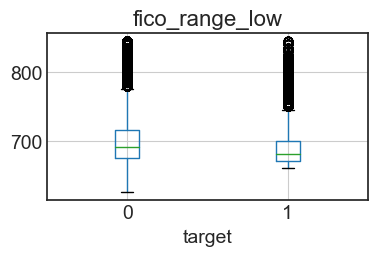

In [14]:
boxplot_fico(loans_init)

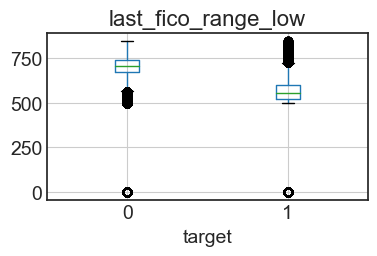

In [15]:
boxplot_fico(loans_init, 'last_fico_range_low')

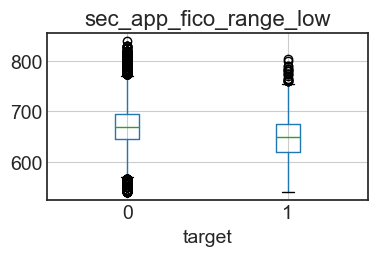

In [16]:
boxplot_fico(loans_init, 'sec_app_fico_range_low')

In [17]:
loans_init.groupby('application_type')[['fico_range_low', 'sec_app_fico_range_low']] \
    .agg(['min', 'max', 'median', 'mean'])

fico_range_low                            \
                            min    max median        mean   
application_type                                            
Individual                625.0  845.0  690.0  696.026669   
Joint App                 660.0  845.0  695.0  704.284690   

                 sec_app_fico_range_low                            
                                    min    max median        mean  
application_type                                                   
Individual                          NaN    NaN    NaN         NaN  
Joint App                         540.0  840.0  665.0  665.970209

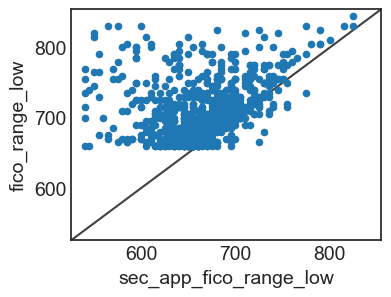

In [18]:
# Scatter plot with x=y line
# https://stackoverflow.com/questions/25497402
loans_init[loans_init['application_type'] == 'Joint App'] \
    [['fico_range_low', 'sec_app_fico_range_low']] \
    .sample(1000) \
    .plot(x='sec_app_fico_range_low', y='fico_range_low', 
          kind='scatter', figsize=(4,3))
lims = [
    np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),
    np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]) 
]
plt.gca().set_xlim(lims)
plt.gca().set_ylim(lims)
plt.gca().plot(lims, lims, 'k-', alpha=0.75, zorder=0)

Takeaways:
  * I don't need to use both the high and low range features, just low should be enough
  * There is a correlation between default and the second app's fico (for those with second applications), which may be of interest. 
  * Most of the time, the second applicant has the lower interest rate, often much lower.

## Special Processing of Some Features
I plan to use a tree-based model and so I am OK with ordinal or thresholded values

##### Term - extract number of months

In [19]:
def term_extract(instr):
    try:
        time = instr.split()[1].lower()
    except:
        return None
    
    if 'month' in time:
        return int(instr.split()[0])
    elif 'year' in time:
        return int(instr.split()[0]) * 12
    
    return None

In [20]:
loans_init['term'] = loans_init['term'].apply(term_extract)

##### Employment Length - extract years

In [21]:
def emp_length_extract(instr):
    if instr == '< 1 year':
        return 0
    elif instr == '10+ years':
        return 10
    
    try:
        time = instr.split()[1].lower()
    except:
        return None
    
    if 'year' in time:
        return int(instr.split()[0]) 
    
    return None

In [22]:
loans_init['emp_length'] = loans_init['emp_length'].apply(emp_length_extract)

##### (Sub) Grade - Use float value to encode an ordinal rating 
I do not use this feature in the final model as its meaning is proprietory and it is extremely predictive.

In [23]:
def ord_grade(grade_str):
    """ Encode the detailed grade.  Smaller values are better.
    Take the letter grade as a whole number, using its ASCII code
    relative to "A".  Get sub-grades as decimals."""
    
    # Get the whole part of the encoded value
    try:
        grade_base = ord(grade_str[0].upper()) - ord('A')
    except:
        return None
    
    # Get the decimal portion
    try:
        grade_dec = np.min([(int(grade_str[1]) - 1) * 0.2, 0.8])
    except:
        return grade_base
    
    return grade_base + grade_dec

In [24]:
loans_init['sub_grade'] = loans_init['sub_grade'].apply(ord_grade)

##### Verification status - make binary

In [25]:
loans_init['verification_status'] = np.where(loans_init['verification_status'] \
                                                .isin(['Source Verified', 'Verified']),
                                             1, 0)

##### Application type - make binary
I wind up not using this feature in the model, either, as it does not contribute to the model if we include the second application FICO.

In [26]:
loans_init['application_type'] = np.where(loans_init['application_type'] \
                                                 .str.lower().str.contains('joint'),
                                          1, 0)

##### Initial list status - make binary

In [27]:
loans_init['initial_list_status'] = np.where(loans_init['initial_list_status'] =='w', 1, 0)

## One Hot Encode Remaining Strings

##### Function to one-hot encode features, keeping the top categories


In [28]:
def one_hot_encode_thresh(ser, num_levels_keep = 3,
                          min_pct = 0.01,
                          other_level_name = 'ZZ_OTHER',
                          prefix_sep = '__'):
    """ One hot encode a feature, keeping only the most commmon levels,
    determined by a max number and percent threshold.  Any other categories 
    will be put into an "other" bucket.  The level name strings are 
    normalized,so they contain only alphanumerics and underscores.  Level
    names also capitalized.
      Inputs:
          ser:  The series to one hot encode
          num_levels_keep: Number of levels to retain
          min_pct: Min percent of population to retain a level,
              regardless of num_levels_keep 
          other_level_name: String used to label the other 
              category, if applicable.
          prefix_sep:  Separator for the one-hot encoding
          prefix:  One-hot encoding prefix
      Value:  A data frame containing the one-hot encoded values"""
    
    # Get the most common categories
    all_value_counts = ser.value_counts(normalize=True)
    all_levels = all_value_counts.index.tolist()
    top_feat = all_value_counts[all_value_counts >= min_pct] \
        .index.tolist()[0:num_levels_keep]

    # Get the levels to keep, up to the max
    # If we have only one level in "other", don't renane it
    if len(all_levels) > len(top_feat) + 1:
        top_feat.append(other_level_name)
    elif len(all_levels) == len(top_feat) + 1:
        top_feat = all_levels
        
    # Make feature categorical
    cat_feat = pd.Categorical(ser, categories=top_feat)
    
    # Normalize category strings, if necessary
    cat_rename_dict = {k: re.sub('[^0-9a-zA-Z_]+', '', k).upper() for k in cat_feat.categories}
    cat_feat = cat_feat.rename_categories(cat_rename_dict)
    
    # One hot encode
    return pd.get_dummies(cat_feat, prefix = ser.name, prefix_sep = prefix_sep)

##### Encode remaining string features

In [29]:
one_hot_feat = set(loans_init[setup.predictor_features].select_dtypes(include=['object']).columns) - \
    set(['term', 'emp_length', 'sub_grade', 'verification_status', 'application_type', 'initial_list_status'])

In [30]:
loans_onehot = pd.concat([one_hot_encode_thresh(loans_init[d]) for d in one_hot_feat],
                         axis=1)

In [31]:
loans_onehot.shape

(1345310, 4)

##### Save binary features

In [32]:
binary_features = list(loans_onehot.columns) + \
    [f for f in ['application_type', 'verification_status', 'initial_list_status'] \
     if f in setup.predictor_features]
print(binary_features)

['home_ownership__MORTGAGE', 'home_ownership__RENT', 'home_ownership__OWN', 'home_ownership__ZZ_OTHER', 'verification_status', 'initial_list_status']


In [33]:
# Save the binary list features
pd.DataFrame({'feature':binary_features}) \
    .drop_duplicates() \
    .to_csv(Path(setup.temp_path).joinpath('01_REPORT_predictor_features_binary.csv'))

##### Finalize dataset, keeping only selected features

In [64]:
# Keep only selected features
used=set()
feat_list = [f for f in setup.info_features + setup.predictor_features + ['target'] \
             if f in loans_init.columns and f not in used \
             and f not in loans_onehot and (used.add(f) or True)]

In [67]:
loans_fin = pd.concat([loans_init[feat_list].reset_index(), loans_onehot], 
                      axis=1)

In [68]:
loans_fin.shape

(1345310, 35)

In [69]:
loans_fin.head(3)

,index,id,grade,sub_grade,hardship_flag,debt_settlement_flag,hardship_amount,settlement_amount,addr_state,purpose,...,initial_list_status,num_actv_bc_tl,mort_acc,pub_rec,revol_bal,target,home_ownership__MORTGAGE,home_ownership__RENT,home_ownership__OWN,home_ownership__ZZ_OTHER
0,0,68407277,C,2.6,N,N,NaN,NaN,PA,debt_consolidation,...,1,2.0,1.0,0.0,2765.0,0,1,0,0,0
1,1,68355089,C,2.0,N,N,NaN,NaN,SD,small_business,...,1,5.0,4.0,0.0,21470.0,0,1,0,0,0
2,2,68341763,B,1.6,N,N,NaN,NaN,IL,home_improvement,...,1,2.0,5.0,0.0,7869.0,0,1,0,0,0


##### Save predictor feature list

In [70]:
predictor_features =  [f for f in setup.predictor_features + list(loans_onehot.columns) \
                       if f in loans_fin.select_dtypes(include=np.number).columns]
pd.DataFrame({'feature':predictor_features}) \
    .drop_duplicates() \
    .to_csv(Path(setup.temp_path).joinpath('01_REPORT_predictor_features.csv'), index=False)

In [71]:
len(predictor_features)

18

In [72]:
print(predictor_features)

['loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc', 'verification_status', 'fico_range_low', 'sec_app_fico_range_low', 'open_acc', 'initial_list_status', 'num_actv_bc_tl', 'mort_acc', 'pub_rec', 'revol_bal', 'home_ownership__MORTGAGE', 'home_ownership__RENT', 'home_ownership__OWN', 'home_ownership__ZZ_OTHER']


## NA Fill
If I were doing an xgboost model, I could skip this step, but I will do a GradientBoostingClassifier instead, as this model type is compatible with the package to calculate Friedman's H (sklearn_gbmi)

In [73]:
na_dset = loans_fin[setup.predictor_features]\
    .select_dtypes('number') \
    .apply(np.isnan) \
    .apply(pd.Series.value_counts)

In [74]:
na_dset_T = na_dset.T.reset_index()
na_features = na_dset_T[~na_dset_T[True].isna()]['index']

##### Second application FICO
Use first app score when missing

In [75]:
loans_fin['sec_app_fico_range_low'] = loans_fin['sec_app_fico_range_low'] \
    .where(~loans_fin['sec_app_fico_range_low'].isna(),
           loans_fin['fico_range_low'])

##### Features to set to 0 (counters)

In [76]:
counter_nas = [c for c in na_features if 
               c.endswith('acc') or c.startswith('num') or 
               c.endswith('acc') or c.startswith('inq') or 
               c.endswith('util') or
               c in ['emp_length']]

In [77]:
loans_fin[counter_nas] = loans_fin[counter_nas].fillna(0)

##### Use median for the rest (if any)

In [78]:
median_feat = [c for c in na_features if 
               not (c in counter_nas + ['sec_app_fico_range_low'])]

In [79]:
if len(median_feat) > 0:
    median_val_dict = loans_fin[median_feat].apply(np.nanmedian).to_dict()
    loans_fin[median_feat] = loans_fin[median_feat] \
        .apply(lambda x: x.fillna(median_val_dict[x.name]))

## Split the data
 * Do 50/50 split to save dataset for future modification
 * With the remaining half, do a 70/15/15 train-test-validation split

##### Create hold-out

In [80]:
[hold_out_data, base_model_data] = train_test_split(loans_fin, test_size=0.5, random_state=645,
                                                    stratify=loans_fin['target'])

In [81]:
hold_out_data.shape

(672655, 35)

In [82]:
base_model_data.shape

(672655, 35)

In [83]:
hold_out_data.to_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_hold_out.parquet'))

##### Do train-test-validation split

In [84]:
[base_train, base_other] = train_test_split(base_model_data, train_size=0.7, random_state=1225,
                                                    stratify=base_model_data['target'])

In [85]:
base_train.shape

(470858, 35)

In [86]:
base_other.shape

(201797, 35)

In [87]:
base_train.to_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [88]:
[base_test, base_val] = train_test_split(base_other, train_size=0.5, random_state=123,
                                                    stratify=base_other['target'])

In [89]:
base_test.shape

(100898, 35)

In [90]:
base_val.shape

(100899, 35)

In [91]:
base_test.to_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet'))
base_val.to_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_val.parquet'))